# Scratch Notebook for Coordinate Systems

In [1]:
# %% Import JAX and enable 64-bit precision
import jax
jax.config.update("jax_enable_x64", True)

In [1]:
# %% Import other libraries
import equinox as eqx
import interpax
import diffrax
import optimistix as optx
import optax

import jax.numpy as jnp
import jax.tree_util as jtu
from dataclasses import dataclass
from functools import partial
import numpy as np
from collections import namedtuple
from typing import NamedTuple
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyvista as pv

from netCDF4 import Dataset

from jaxtyping import ArrayLike, Real

In [2]:
# %% Load my own libraries
%load_ext autoreload
%autoreload 2
from c1lgkt.jax.fields.equilibrium import Equilibrium
import c1lgkt.jax.fields.clebsch as cb
from c1lgkt.jax.fields.clebsch import ClebschMappingBuilder, _objective_uv_params, _objective_uv_params_refine, ThetaMapping, MagneticNullInfo, UvParams
from c1lgkt.jax.fields.field_providers import EikonalFieldProvider
from c1lgkt.jax.fields.geometry_handlers import FieldlinePusher, FieldlineArgs, GeometryHandler
import c1lgkt.jax.particles.particle_motion as particle_motion

In [3]:
# %% Test loading equilibrium
%matplotlib inline
eq = Equilibrium.from_eqdfile('./tests/D3D141451.eqd')

In [4]:
# %% Build Clebsch mapping from equilibrium
clebsch_builder = ClebschMappingBuilder()
theta_map = clebsch_builder.build_theta_map(eq)
#clebsch = clebsch_builder.build_clebsch(theta_map, eq)

In [10]:
# Initial guess for (u,v) parameters based on null locations
nulls = theta_map.nulls
y0 = jnp.array([2*nulls.x1.rz[0] - nulls.axis.rz[0], 2*nulls.x1.rz[1] - nulls.axis.rz[1], 2*nulls.x2.rz[0] - nulls.axis.rz[0], 2*nulls.x2.rz[1] - nulls.axis.rz[1]])
sol = optx.root_find(_objective_uv_params, clebsch_builder.newton_uv_params, y0, args=nulls, throw=False)
# Refine the solution to enforce inertia constraints
#y0_refine = jnp.array([sol.value[0], sol.value[1], sol.value[2], sol.value[3], 0.0, 0.0, 0.0, 0.0])
#sol_refine = optx.root_find(_objective_uv_params_refine, self.newton_uv_params_refine, y0_refine, args=nulls, throw=False)

In [17]:
theta_map_test = ThetaMapping(
    nulls=nulls,
    uv_params=UvParams.from_array(jnp.array([sol.value[0], sol.value[1], sol.value[2], sol.value[3], 0.0, 0.0, 0.0, 0.0]))
)

In [6]:
# %% Test serialisation
#eqx.tree_serialise_leaves('./outputs/clebsch_D3D141451.eqx', theta_map)
#theta_map = eqx.tree_deserialise_leaves('./outputs/clebsch_D3D141451.eqx', theta_map)

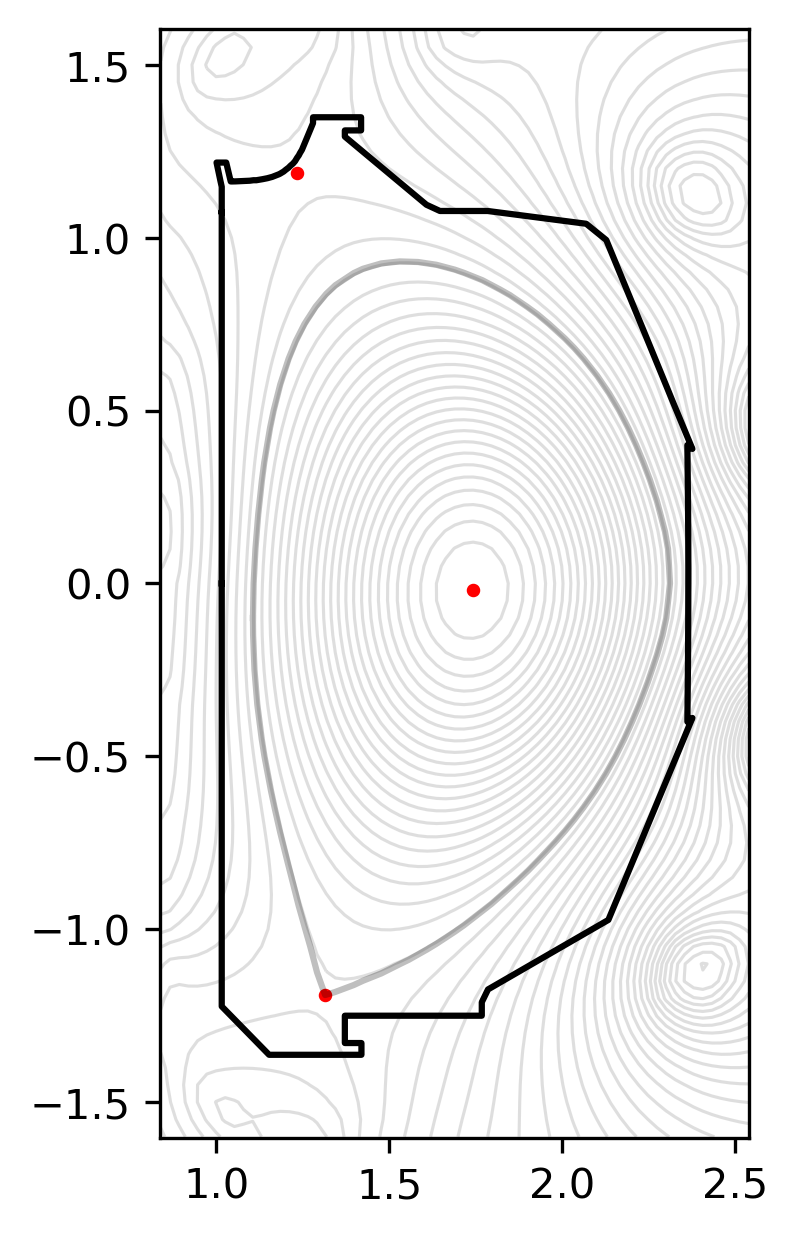

In [6]:
# %% Check the Clebsch variable
plt.figure(dpi=300)

rplot, zplot = jnp.meshgrid(jnp.linspace(eq.rmin, eq.rmax, 512), jnp.linspace(eq.zmin, eq.zmax, 512), indexing='ij')
psiplot = eq.interp_psi(rplot.ravel(), zplot.ravel()).reshape(rplot.shape)
#y0_refine_test = jnp.array([sol.value[0], sol.value[1], sol.value[2], sol.value[3], -1.0, 0.0, 0.0, 0.0])
nulls = theta_map.nulls
thetaplot2 = theta_map(rplot.ravel(), zplot.ravel()).reshape(rplot.shape)
theta_x = theta_map(jnp.array([nulls.x1.rz[0], nulls.x2.rz[0]]), jnp.array([nulls.x1.rz[1], nulls.x2.rz[1]]))

alphaplot = clebsch.interp_alpha(psiplot.ravel(), thetaplot2.ravel()).reshape(rplot.shape)

ax = plt.subplot(111)
eq.plot_magnetic_geometry(ax, alpha=0.25)
ax.scatter(theta_map.nulls.axis.rz[0], theta_map.nulls.axis.rz[1], c='r', s=5)
ax.scatter(theta_map.nulls.x1.rz[0], theta_map.nulls.x1.rz[1], c='r', s=5)
ax.scatter(theta_map.nulls.x2.rz[0], theta_map.nulls.x2.rz[1], c='r', s=5)
#plt.contour(rplot, zplot, thetaplot, levels=jnp.linspace(-np.pi, np.pi, 129), linewidths=0.5, linestyles='dashed')
plt.contour(rplot, zplot, thetaplot2, levels=jnp.linspace(-np.pi, np.pi, 129), linewidths=0.5)
#plt.contour(rplot, zplot, thetaplot2, levels=theta_x, linewidths=0.5)
plt.pcolormesh(rplot, zplot, jnp.cos(3*alphaplot), linewidths=0.5, cmap='PiYG')

In [6]:
# %% Set up eikonal field provider

coefs = np.zeros((2, 4, 6))
coefs[0, 2, 0] = 1.0
coefs[1, 2, 0] = 0.7

theta_x1 = theta_map(jnp.array([theta_map.nulls.x1.rz[0]]), jnp.array([theta_map.nulls.x1.rz[1]]))[0]
theta_x2 = theta_map(jnp.array([theta_map.nulls.x2.rz[0]]), jnp.array([theta_map.nulls.x2.rz[1]]))[0]

field_provider = EikonalFieldProvider(
    clebsch = clebsch,
    n = jnp.array([3, 3], dtype=int),
    omega = jnp.array([0.0, 0.0]),
    psi0 = jnp.array([0.95*eq.psix, 0.95*eq.psix]),
    psi_scale = jnp.array([0.02*eq.psix, 0.02*eq.psix]),
    theta0 = jnp.array([theta_x1 + 0.01, theta_x2 - 0.01]),
    alpha_scale = jnp.array([3.0, 3.0]),
    gh_coefs = jnp.array(coefs)
)


NameError: name 'field_provider' is not defined

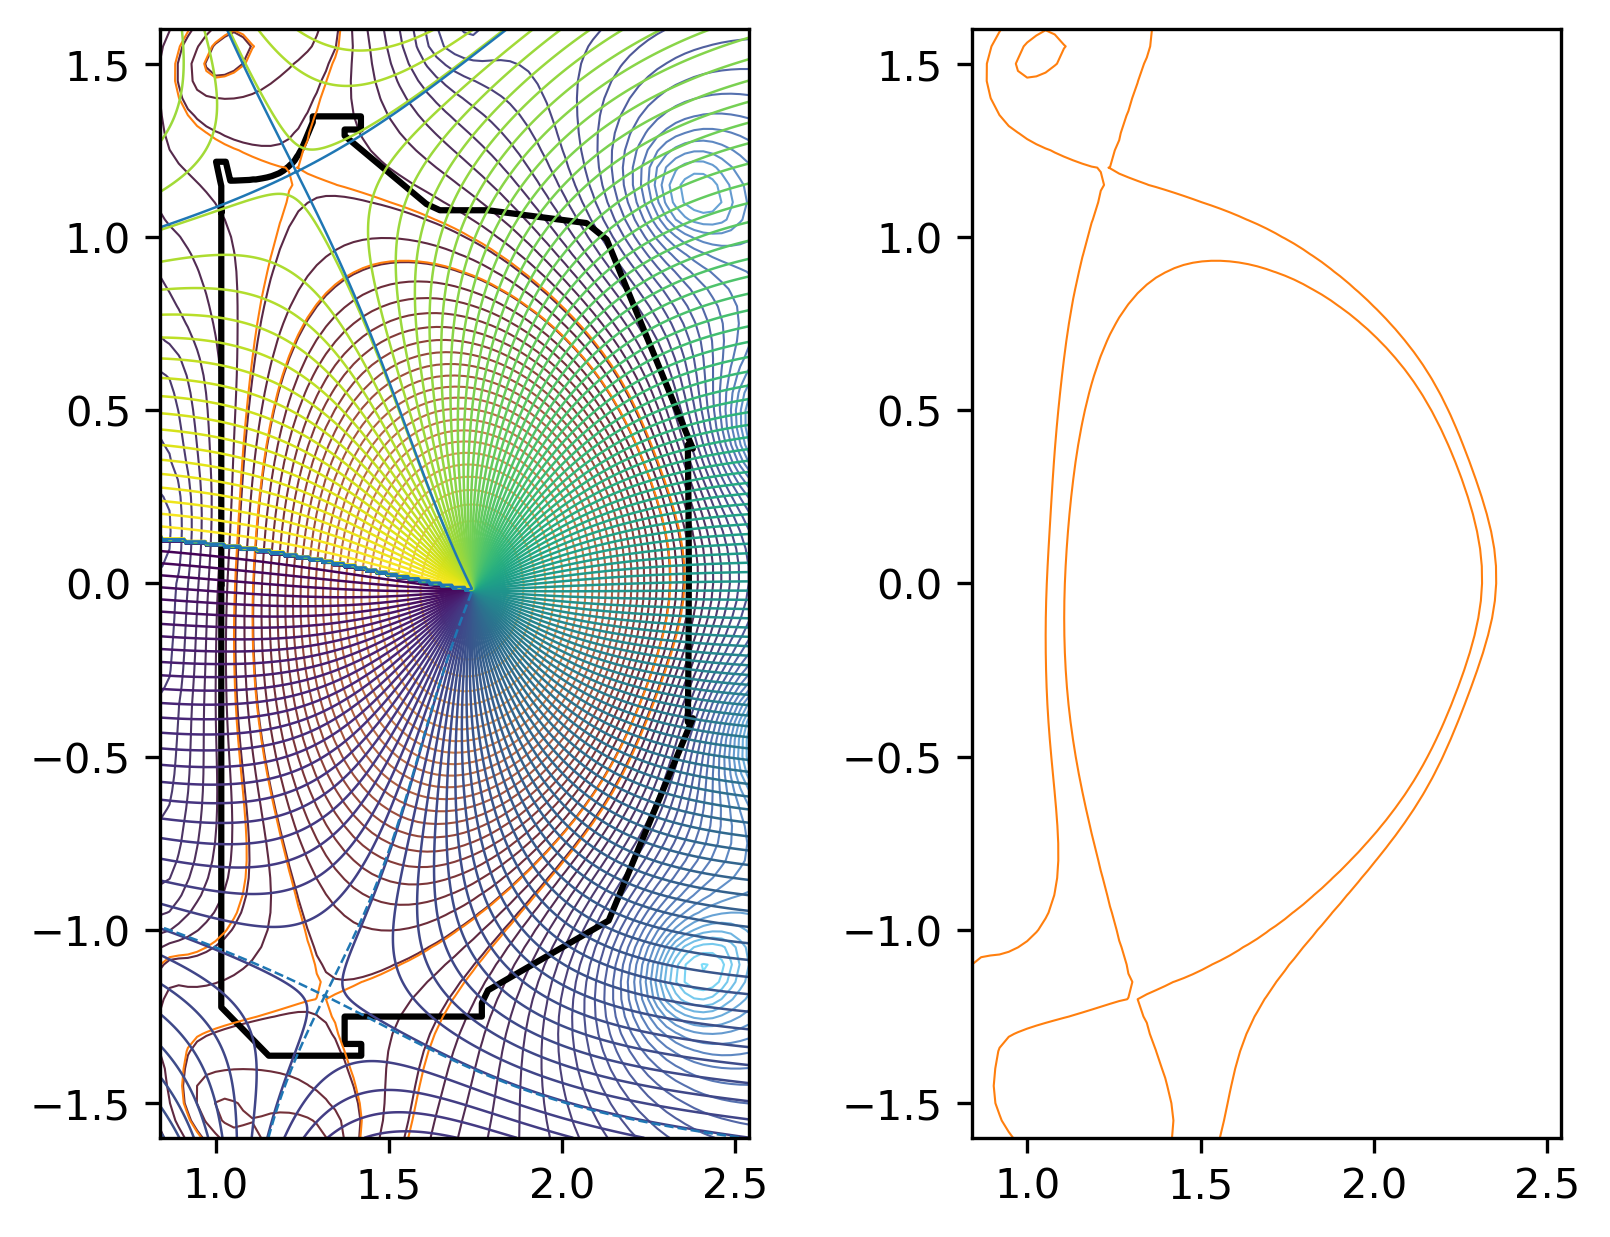

In [5]:
# %% Plot equilibrium
%matplotlib inline
plt.figure(dpi=300)
ax = plt.subplot(121)
ax2 = plt.subplot(122, sharex=ax, sharey=ax)

rgrid = np.linspace(eq.rmin, eq.rmax, 512)
zgrid = np.linspace(eq.zmin, eq.zmax, 512)
rplot, zplot = np.meshgrid(rgrid, zgrid, indexing='ij')

psi_ev, ff_ev = eq.compute_psi_and_ff(jnp.ravel(rplot), jnp.ravel(zplot))
(psi, psidr, psidz, psidrr, psidrz, psidzz) = psi_ev

#uv_y = jnp.array([sol.value[0], sol.value[1], sol.value[2], sol.value[3], 0.2, 0.0, 0.2, 0.0])
theta = theta_map(rplot.ravel(), zplot.ravel())


region = jnp.zeros_like(rplot.ravel())
theta_x = theta_map(jnp.array([theta_map.nulls.x1.rz[0], theta_map.nulls.x2.rz[0]]), jnp.array([theta_map.nulls.x1.rz[1], theta_map.nulls.x2.rz[1]]))

#alpha_grid = interp_alpha(psi.ravel(), theta.ravel())
#field_grid = jnp.cos(5*alpha_grid) * jnp.exp(-0.005*alpha_grid**2) * jnp.exp(-4000*(psi.ravel() - 0.95*eq.psix)**2)




ax.contour(eq.rgrid, eq.zgrid, eq.psirz, levels=64, cmap='managua', linewidths=0.5)
ax.plot(eq.wallrz[0,:], eq.wallrz[1,:], c='k')
ax.contour(eq.rgrid, eq.zgrid, eq.psirz, levels=[theta_map.nulls.x1.psi, theta_map.nulls.x2.psi], colors='tab:orange', linewidths=0.5)
ax.set_aspect('equal')
ax2.set_aspect('equal')

ax2.contour(eq.rgrid, eq.zgrid, eq.psirz, levels=[theta_map.nulls.x1.psi, theta_map.nulls.x2.psi], colors='tab:orange', linewidths=0.5)


ax.contour(rgrid, zgrid, theta.reshape(rplot.shape).T, levels=np.linspace(-np.pi,np.pi,129), linewidths=0.6)


ax.contour(rgrid, zgrid, theta.reshape(rplot.shape).T, levels=np.sort([theta_x[0], theta_x[1]]), linewidths=0.6, colors='tab:blue')

field_grid = field_provider(0.0, psi.ravel(), theta.ravel(), jnp.zeros_like(theta.ravel()))
fmax = jnp.max(jnp.abs(field_grid[1]))
ax2.pcolormesh(rgrid, zgrid, field_grid[1].reshape(rplot.shape).T, shading='gouraud', cmap='PiYG', vmin=-1.0, vmax=1.0)




In [ ]:
# %% Initialize FieldlinePusher; this is to check the results of the clebsch mapping against fieldline tracing
fieldline_pusher = FieldlinePusher()
geom = GeometryHandler(eq, fieldline_pusher)

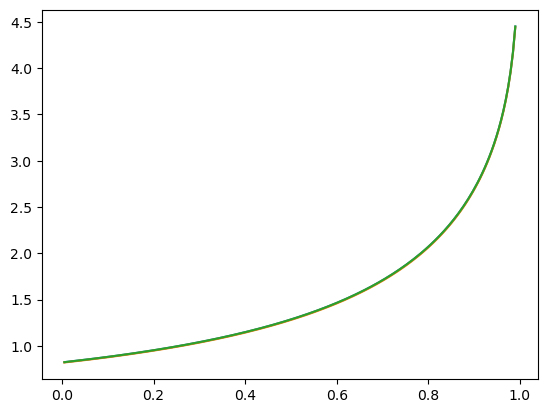

In [ ]:

plt.figure()

plt.plot(geom.psi_surf/eq.psix, -geom.q_surf)

alpha0 = clebsch.interp_alpha(geom.psi_surf, jnp.full_like(geom.psi_surf, -jnp.pi))
alpha1 = clebsch.interp_alpha(geom.psi_surf, jnp.full_like(geom.psi_surf, jnp.pi))

alpha2 = clebsch.interp_alpha(geom.psi_surf, jnp.full_like(geom.psi_surf, 0.0))
alpha3 = clebsch.interp_alpha(geom.psi_surf, jnp.full_like(geom.psi_surf, 2*jnp.pi))
plt.plot(geom.psi_surf/eq.psix, -(alpha1 - alpha0)/(2*jnp.pi))
plt.plot(geom.psi_surf/eq.psix, -(alpha3 - alpha2)/(2*jnp.pi))